# Multitask Notebook

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gpflow as gpf
import tensorflow as tf
import gpflow
import tensorflow as tf
import time

from SpatialScan.preprocessing import *
from SpatialScan.multi_scoot_gp import *
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline
from SpatialScan.timeseries import *
from sklearn.preprocessing import MinMaxScaler

MAXITER = ci_niter(2000)

Read in our JamCam Data, it has already been preprocessed, so the data should be fairly "well behaved"

### Multivariate Autoregressive GP for Jamcams

In [2]:
DF = pd.read_csv('multi_jam2.csv', index_col=False, parse_dates=[4, 5])

Initialise our Multivaraite Jamcam class

In [3]:
MVGP=JamCamMVGP()

Produce a training and test set from the data

In [20]:
prediction_start = DF["measurement_end_utc"].max() - np.timedelta64(4, "D") + np.timedelta64(2, "h")
train = DF[DF["measurement_end_utc"]<= prediction_start]
test = DF[DF["measurement_end_utc"] > prediction_start]

To see the format of the Auroregressive data, lets convert the test set into autoregressive data to observe it

In [81]:
#create dataset for one detector
test1 = test[test["detector_id"]==test["detector_id"].unique()[0]]
train1 = train[train["detector_id"]==train["detector_id"].unique()[0]]

x, y = MVGP.create_dataset(test1, "car", days = 1)
print(np.array(x).shape)
print(len(y))

(3, 46)
46


As you can see above, X has the same length as y, with 3 columns. We now show in the plot below at how the x and y arre the same data, but y is ahead by one day

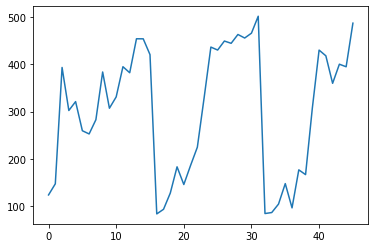

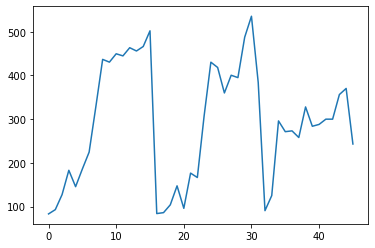

In [22]:
plt.plot(x[0]) #x[0] is the cars
plt.show()
plt.plot(y)
plt.show()

lets train a model for the same detector, using the training data. the train method returns the trained model along with scalers

In [83]:
model, scaler_x, scaler_y = MVGP.train(train, test["detector_id"].unique()[0], "car", days = 1)

In [84]:
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.12115256574330223
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.012845064294557694
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(3,)",float64,[1.43407431 0.83786813 1.25700751]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.07608869028567625


now lets use our model to see if we can predict y from x

In [85]:
X = np.array(x).T
X = scaler_x.fit_transform(X)
mean, var = model.predict_f(X)
# mean = mean.numpy().flatten()
# var = var.numpy().flatten()
mean = scaler_y.inverse_transform(mean).flatten()
var = scaler_y.inverse_transform(var).flatten()

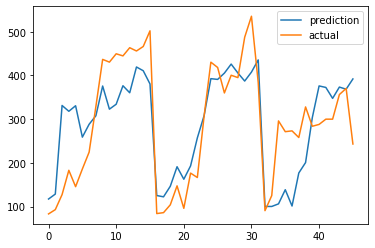

In [86]:
plt.plot
plt.plot(mean, label= "prediction")
plt.plot(y, label= "actual")
plt.legend()
plt.show()

This can all be automated for multiple detectors at once, and validated against actual counts, by calling count_baseline

In [112]:
CB2 = MVGP.count_baseline(train, test, detectors=[train["detector_id"].unique()[0]], target="car", days=1)

1.01251


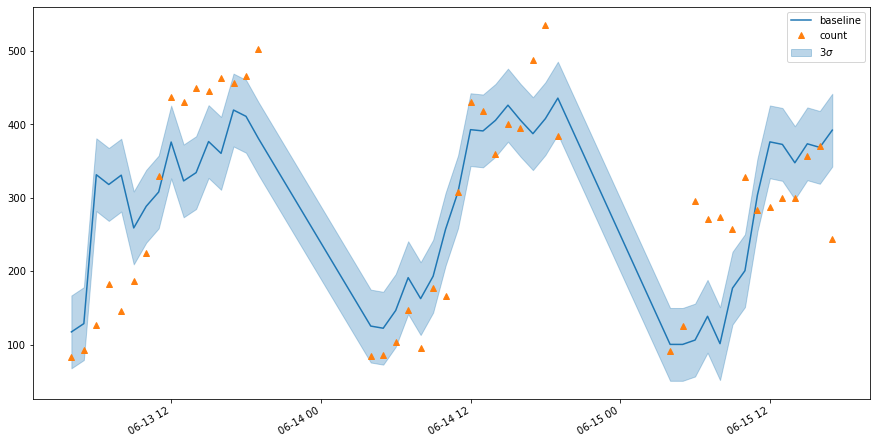

In [113]:
forecast_plot(CB2)

In [114]:
MAPE(CB2)

31.994070940387008

## Multioutput GP for Jamcams

first imitialise JamcamMOGP object

In [59]:
MOGP=JamCamMOGP()

Because this doesn't use autoregressive data, we can go straight in and train our model for one jamcam

In [101]:
model, scaler = MOGP.train(train1, method = "coregional")

Our model has a lot of hyper parameters, does to the mixing matrices

In [102]:
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].kernels[0].base_kernel.variance SVGP.kernel.kernels[1].kernels[0].base_kernel.variance SVGP.kernel.kernels[2].kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1.4733135653472766
SVGP.kernel.kernels[0].kernels[0].base_kernel.lengthscales SVGP.kernel.kernels[1].kernels[0].base_kernel.lengthscales SVGP.kernel.kernels[2].kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.4469462541205632
SVGP.kernel.kernels[0].kernels[0].period SVGP.kernel.kernels[1].kernels[0].period SVGP.kernel.kernels[2].kernels[0].period,Parameter,Softplus,,True,(),float64,24.154941733475766
SVGP.kernel.kernels[0].kernels[1].base_kernel.variance SVGP.kernel.kernels[1].kernels[1].base_kernel.variance SVGP.kernel.kernels[2].kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.34686797170758654
SVGP.kernel.kernels[0].kernels[1].base_kernel.lengthscales SVGP.kernel.kernels[1].kernels[1].base_kernel.lengthscales SVGP.kernel.kernels[2].kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.9203736338496251
SVGP.kernel.kernels[0].kernels[1].period SVGP.kernel.kernels[1].kernels[1].period SVGP.kernel.kernels[2].kernels[1].period,Parameter,Softplus,,True,(),float64,176.53821090779533
SVGP.kernel.kernels[0].kernels[2].variance SVGP.kernel.kernels[1].kernels[2].variance SVGP.kernel.kernels[2].kernels[2].variance,Parameter,Softplus,,True,(),float64,0.5668359423882156
SVGP.kernel.kernels[0].kernels[2].lengthscales SVGP.kernel.kernels[1].kernels[2].lengthscales SVGP.kernel.kernels[2].kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,8.642951521402214
SVGP.kernel.W,Parameter,,,True,"(3, 3)",float64,"[[-0.27927027, 0.00489013, -0.19452441..."
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.06120140919669867


 Now form prediction of test set, and compare to actual counts

In [103]:
X = ((test1["measurement_end_utc"] - train1["measurement_end_utc"].min())
            .astype("timedelta64[h]")
            .to_numpy()
            .reshape(-1, 1))
mean, var = model.predict_f(X)
mean = scaler.inverse_transform(mean)
var = scaler.inverse_transform(var)
mean=mean.T

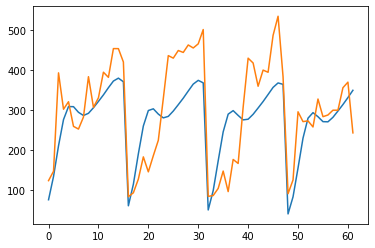

In [109]:
plt.plot(mean[0])
plt.plot(test1["n_vehicles_in_interval_car"].to_numpy())

we can automate this process with count baseline, and compare using the plot forecast. This can handle multiple detectors at once

In [105]:
CB=MOGP.count_baseline(train, test, detectors=[train["detector_id"].unique()[0]], method="coregional")

In [45]:
def MAPE(df):
    return 100*(abs((df[df["count"]>0]["count"]-df[df["count"]>0]["baseline"])/df[df["count"]>0]["count"]).mean())

In [106]:
MAPE(CB)

28.873871952504654

1.01251


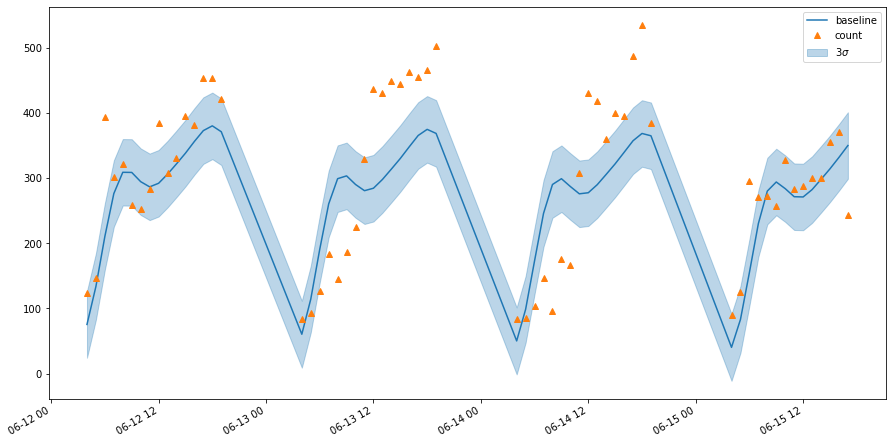

In [107]:
forecast_plot(CB)